**Name**

* **Yu-Chih (Wisdom) Chen**
* **Devon Delgado**
* **Xiaobing Xu**
* **Peter Ye**

**Date**

**11/16/2024**

# Fake Job Description Prediction Dataset

## Overview
This dataset is designed for developing classification models to identify fraudulent job postings. It contains approximately 18,000 job descriptions, with around 800 labeled as fake.

## Dataset Details
- **Total Entries**: ~18,000 job descriptions
- **Fraudulent Entries**: ~800
- **Data Types**: Textual information and meta-information about jobs

## Source
The University of the Aegean | Laboratory of Information & Communication Systems Security
(http://emscad.samos.aegean.gr/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import contractions
from unidecode import unidecode
import string
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import nltk
from transformers import AutoTokenizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yzysnake/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Load Data

In [ ]:
df = pd.read_csv('fake_job_postings.csv') # Change it to data source

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 2. Exploratory Data Analysis (EDA)

In [4]:
# Get the dimensions of the Dataset
print("Dimensions of the Dataset (Rows, Columns):")
df.shape

Dimensions of the Dataset (Rows, Columns):


(17880, 18)

In [5]:
# Removing any leading, and trailing whitespaces in columns
df.columns = df.columns.str.strip()

In [6]:
# Check if any duplicate rows in dataset
df.duplicated().sum()

0

In [7]:
# Getting an overview of the features and their types in the dataset
print("Overview of the features and their types:")
df.info()

Overview of the features and their types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry   

In [8]:
# Count the number of columns with dtype 'object'
object_cols = df.select_dtypes(include=['object']).columns
num_object_cols = len(object_cols)

# Count the number of columns with dtype 'int64'
int_cols = df.select_dtypes(include=['int64']).columns
num_int_cols = len(int_cols)

print(f"Number of columns with object dtype: {num_object_cols}")
print(f"Number of columns with int64 dtype: {num_int_cols}")

Number of columns with object dtype: 13
Number of columns with int64 dtype: 5


### a. Missing Values

In [9]:
print("Display Missing values in the dataset: ")
print("\n")

print(df.isnull().sum())

Display Missing values in the dataset: 


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [10]:
# View percentage of missing values per column
print('Percent of Null Values in Each Column:\n')
print(df.isnull().sum()/df.shape[0]*100)

Percent of Null Values in Each Column:

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


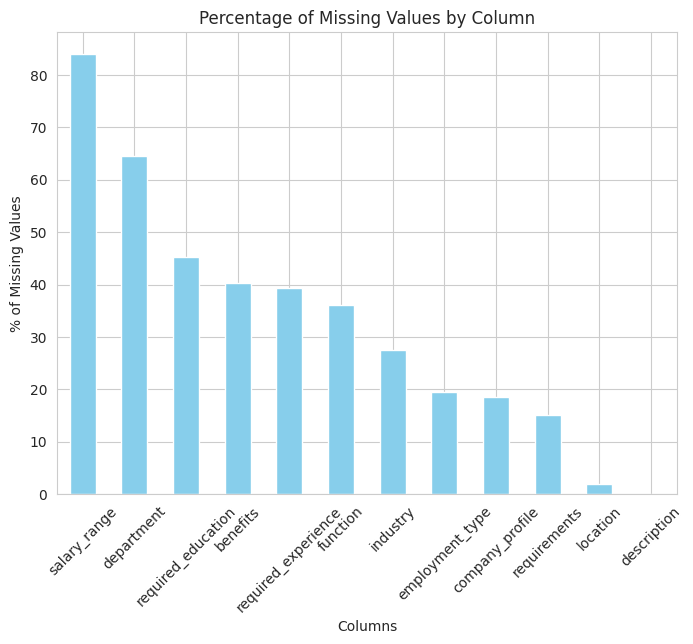

In [11]:
# Count and display percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
missing_percent.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('% of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

### b. Visualizatioin

In [12]:
#Differentiate categorical data and numerical data
df_num = df[['telecommuting','has_company_logo','has_questions','fraudulent','salary_range']]
df_cat = df[['title', 'location','company_profile', 'requirements','employment_type',
       'required_experience', 'required_education', 'industry', 'function']]

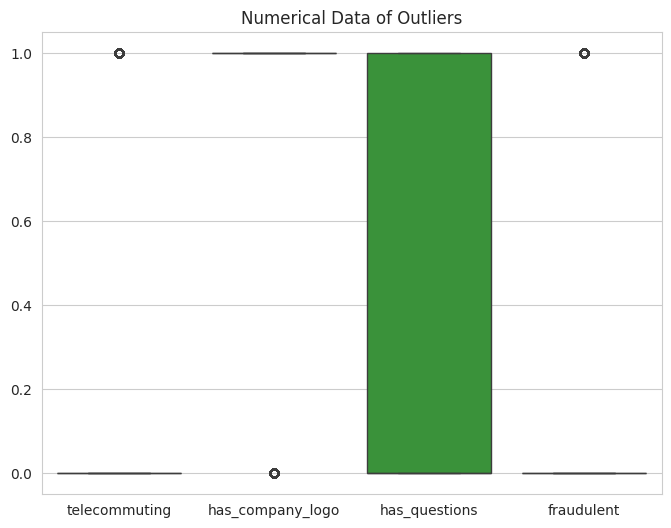

In [13]:
# Checking for Outliers in numerical data
plt.figure(figsize=[8,6])
sns.boxplot(data = df_num)
plt.title("Numerical Data of Outliers")
plt.show()

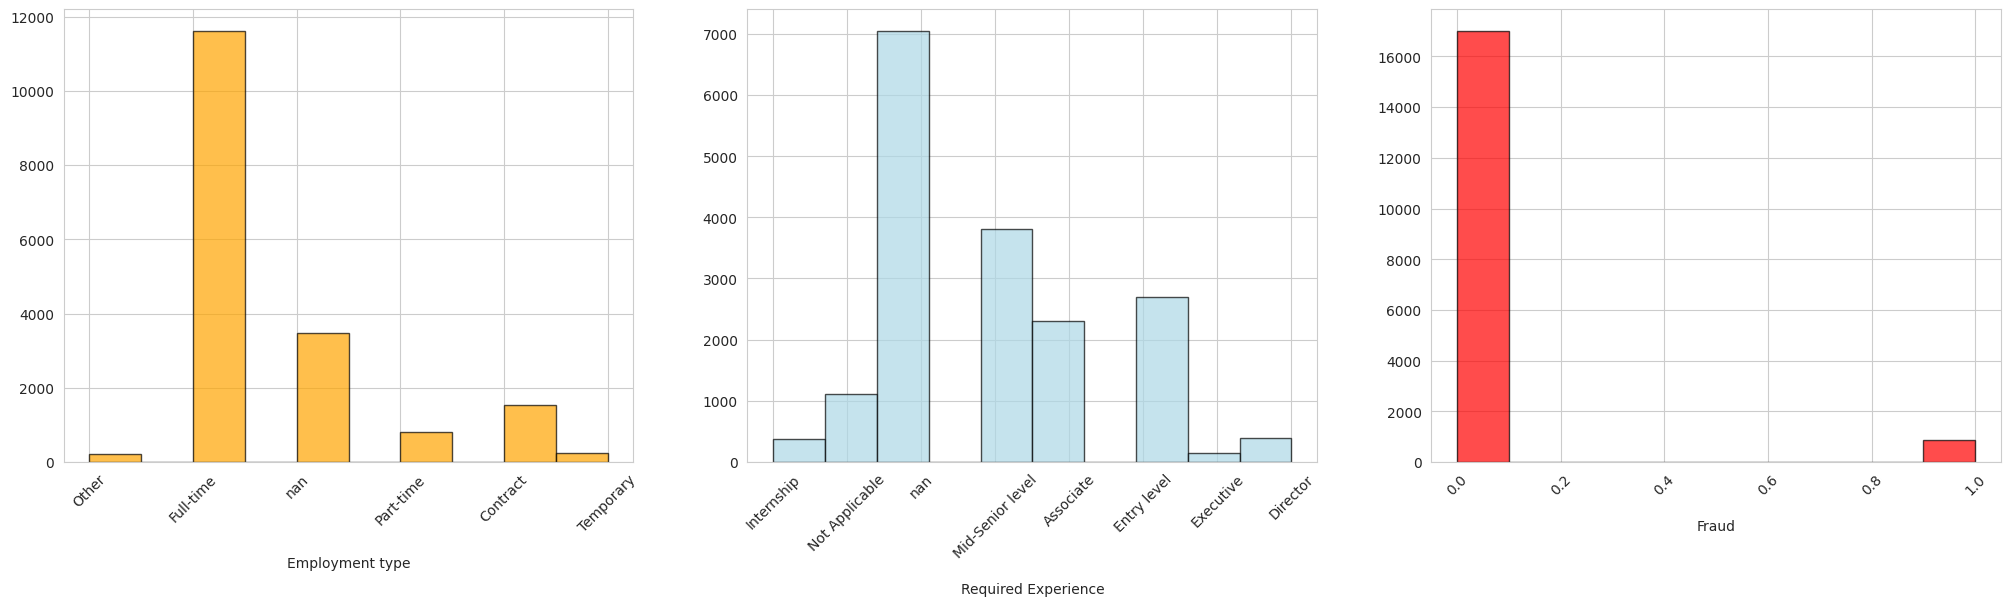

In [14]:
# Plots to see the distribution of the continuous features individually
plt.figure(figsize= (25,20))
plt.subplot(3,3,1)
# Convert 'employment_type' to string type before plotting
plt.hist(df.employment_type.astype(str), color='orange', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nEmployment type')
plt.xticks(rotation=45)

plt.subplot(3,3,2)
# Convert 'required_experience' to string type before plotting
plt.hist(df.required_experience.astype(str), color='lightblue', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nRequired Experience')
plt.xticks(rotation=45)

plt.subplot(3,3,3)
plt.hist(df.fraudulent, color='red', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nFraud')
plt.xticks(rotation=45)


plt.show()

/tmp/ipykernel_395423/132576963.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='function',data=df,palette='Set1')


<Axes: title={'center': 'Number of Job Function'}, xlabel='function', ylabel='count'>

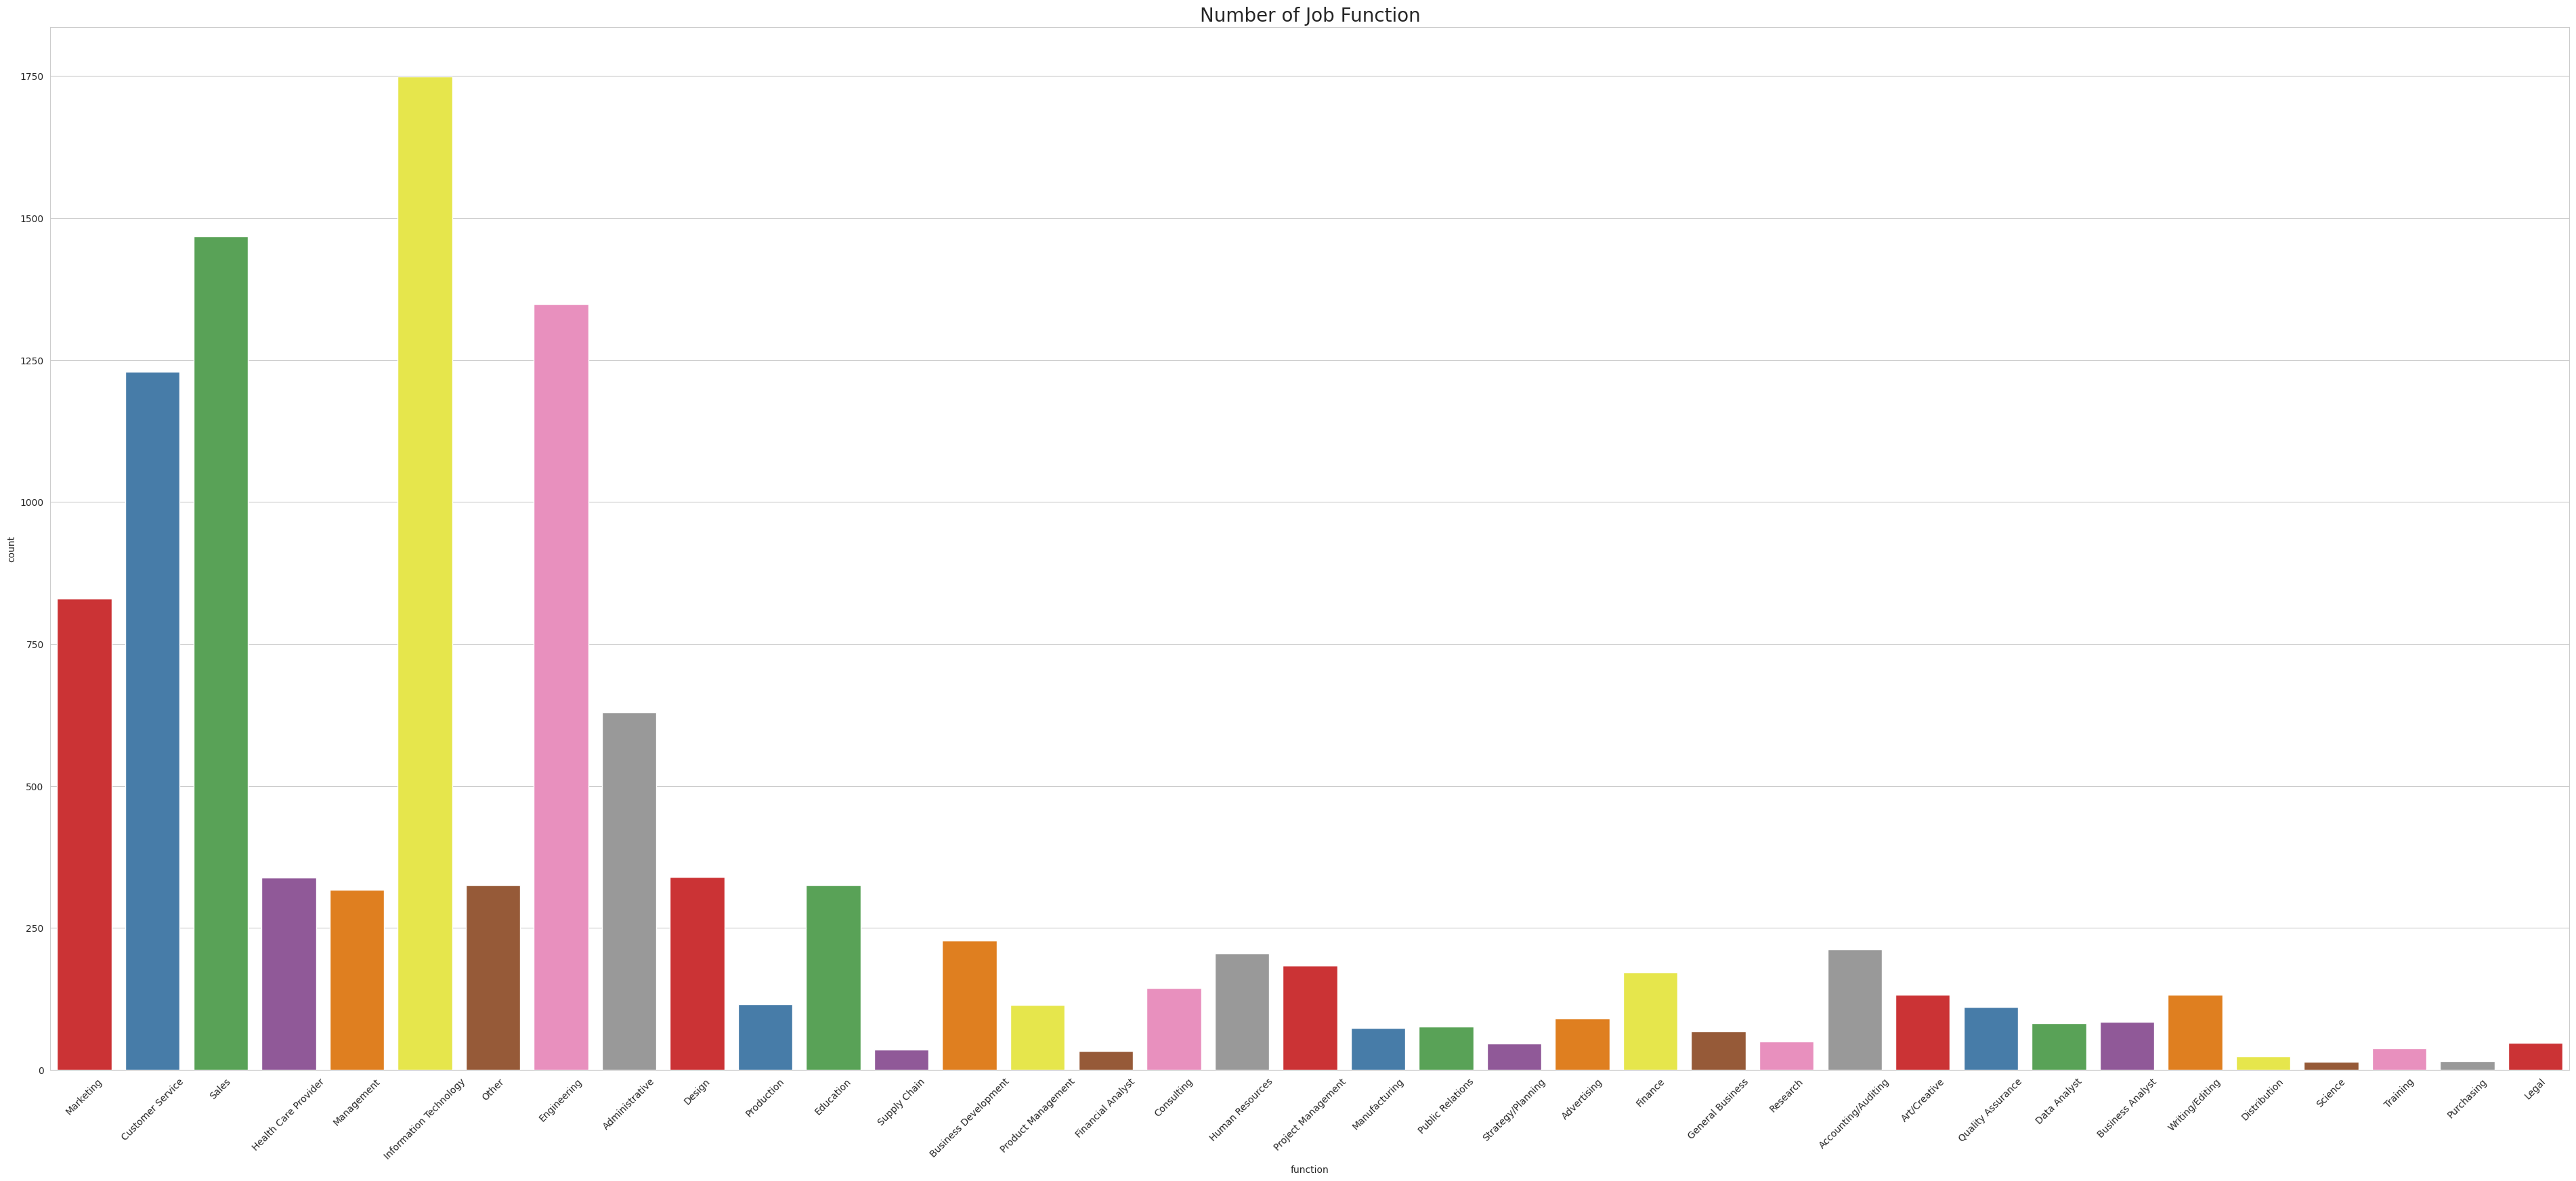

In [15]:
# Number of Job Function
plt.figure(figsize=(48,20))
plt.xticks(rotation=45)
plt.title("Number of Job Function", fontsize=20)
sns.set_style("darkgrid")
sns.countplot(x='function',data=df,palette='Set1')

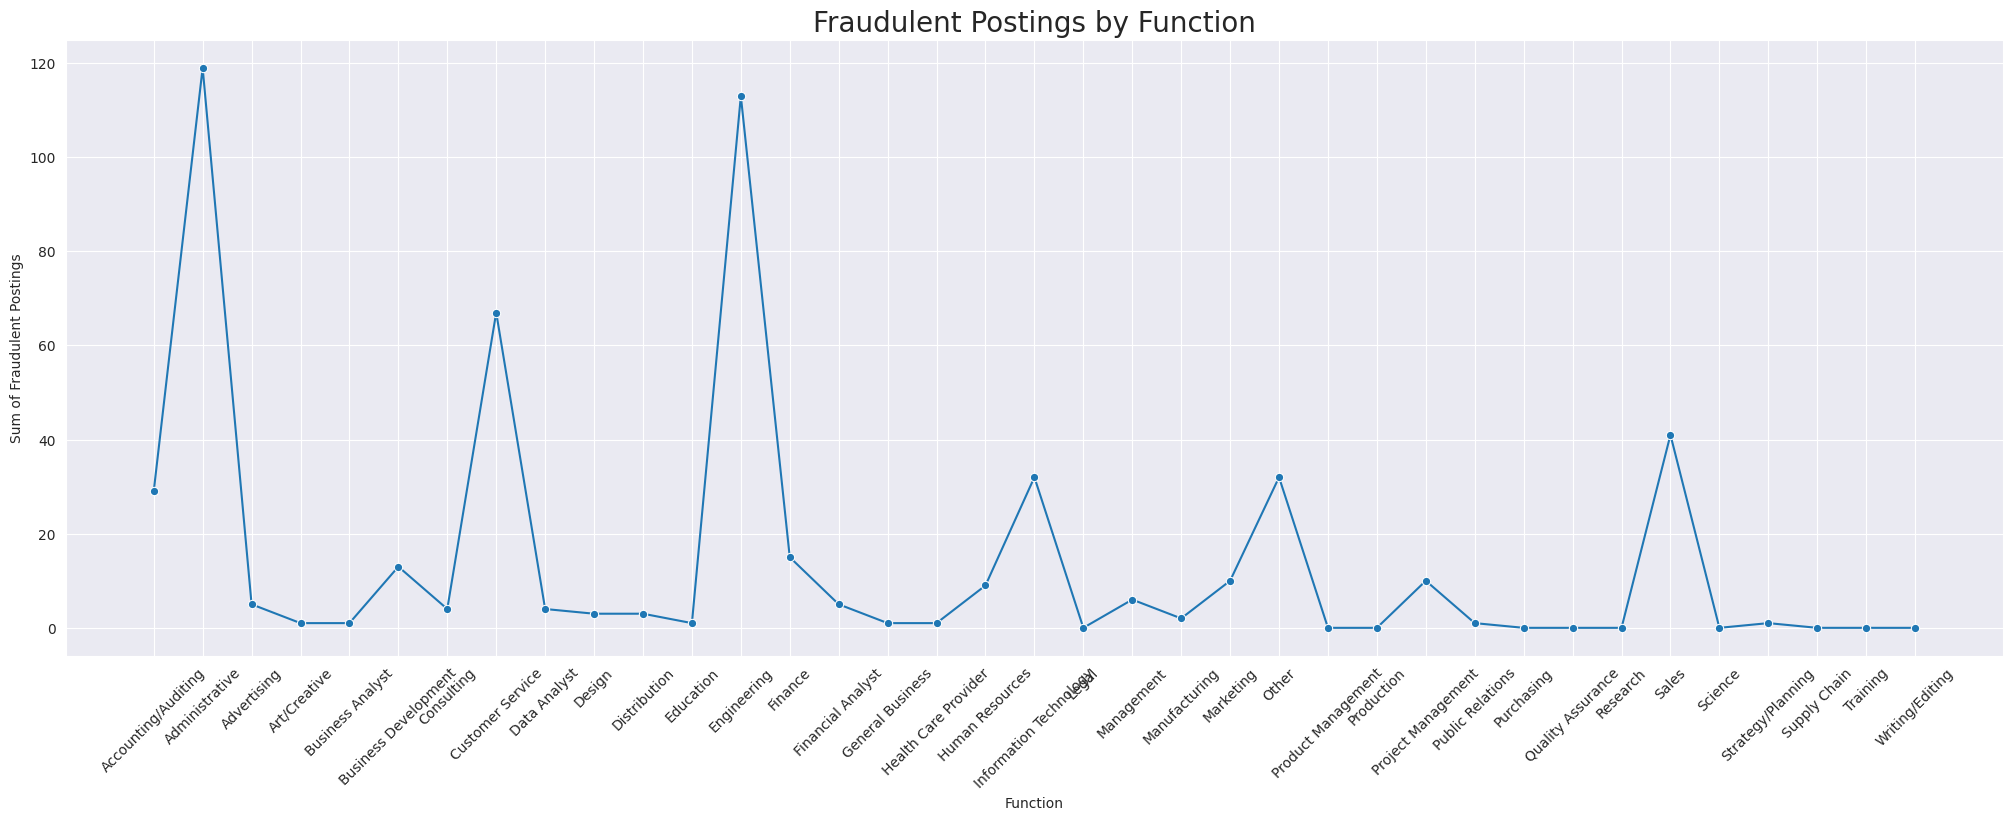

In [ ]:
# Calculate the sum of fraudulent postings by function
fraudulent_summary = df.groupby('function')['fraudulent'].sum().reset_index()

plt.figure(figsize=(25, 8))
sns.lineplot(data=fraudulent_summary, x='function', y='fraudulent', marker='o')
plt.title('Fraudulent Postings by Function', fontsize = 20)
plt.xlabel('Function')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<ipython-input-127-77320201554f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=df, palette= fraud_colors)


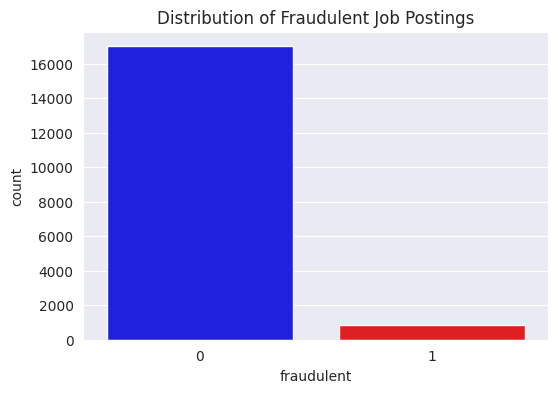

In [ ]:
# Bar plot for fraudulent (target) feature
fraud_colors = ['blue', 'red']
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df, palette= fraud_colors)
plt.title('Distribution of Fraudulent Job Postings')
plt.show()

<ipython-input-128-2e463767b6da>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum, palette='Set2')


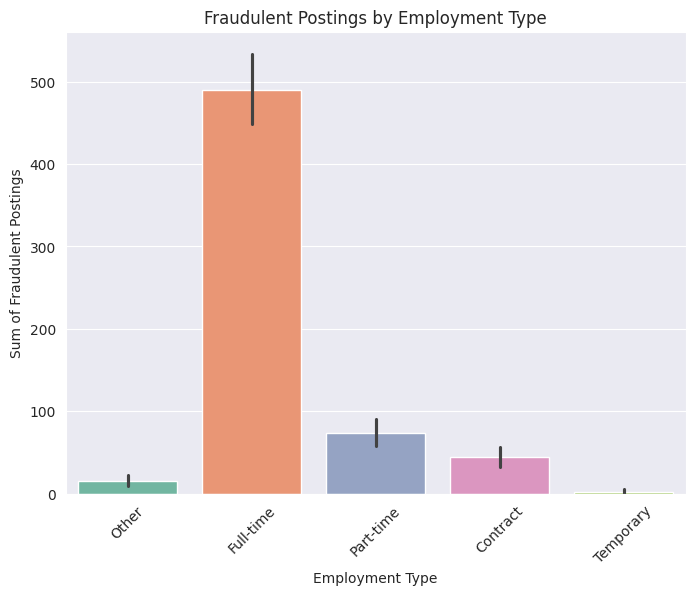

In [ ]:
# Bar plot for employment_type
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum, palette='Set2')
plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

<ipython-input-129-fe6fe1845e9f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=sum, palette="Set1")


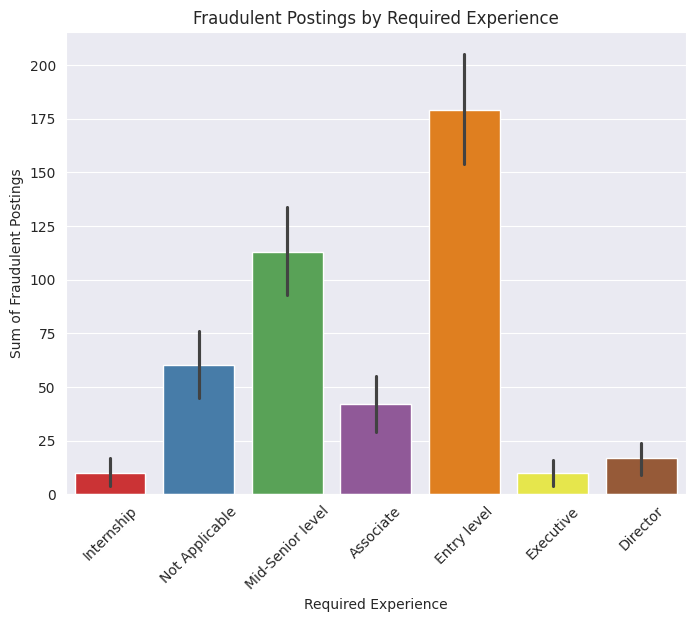

In [ ]:
# Bar plot for required_experience
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=sum, palette="Set1")
plt.title('Fraudulent Postings by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

<ipython-input-130-c9b819b10f9f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='required_education', y='fraudulent', estimator=sum, palette="Set3")


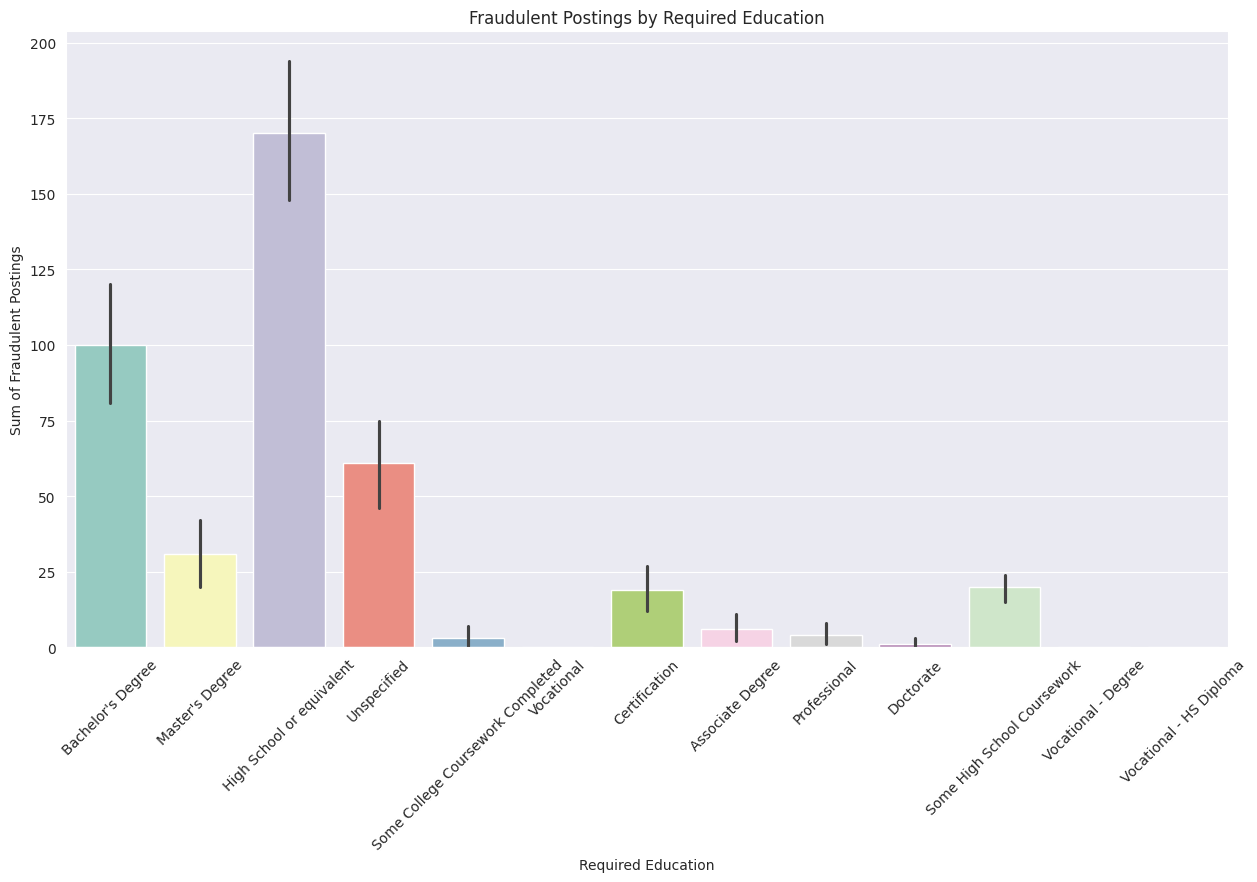

In [ ]:
# Bar plot for required_education
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='required_education', y='fraudulent', estimator=sum, palette="Set3")
plt.title('Fraudulent Postings by Required Education')
plt.xlabel('Required Education')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation = 45)
plt.show()

### c. Data Preprocessing

In [ ]:
# Select the Features with Domain Knowledge

def select_features(df):
    """Select relevant features from the dataset"""
    selected_features = ['title', 'description', 'requirements', 'company_profile',
                        'benefits', 'location', 'employment_type', 'required_experience',
                        'required_education', 'industry', 'function', 'telecommuting',
                        'has_company_logo', 'has_questions', 'fraudulent']

    return df[selected_features]

In [ ]:
# Handling Missing Values

def handle_missing_values(df):
    """Handle missing values in the dataset"""
    # Create missing value indicators
    missing_indicators = {}
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            missing_indicators[f'{col}_is_missing'] = df[col].isnull().astype(int)

    # Handle text columns
    text_columns = ['title', 'description', 'requirements', 'company_profile', 'benefits']
    for col in text_columns:
        df[col] = df[col].fillna('')

    # Handle categorical columns
    categorical_mappings = {
        'location': 'Unknown Location',
        'employment_type': 'Not Specified',
        'required_experience': 'Not Specified',
        'required_education': 'Not Specified',
        'industry': 'Unknown Industry',
        'function': 'Unknown Function'
    }

    for col, placeholder in categorical_mappings.items():
        df[col] = df[col].fillna(placeholder)

    # Add missing indicators to the dataframe
    for col_name, indicator in missing_indicators.items():
        df[col_name] = indicator

    return df

In [ ]:
# Clean the text columns & Tokenized

tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

def clean_text(text):
    """Clean and tokenize text data"""
    if pd.isna(text) or text == '':
        return ''

    # Basic cleaning
    soup = BeautifulSoup(str(text), "html.parser")
    text = soup.get_text(separator=" ")
    text = ' '.join(text.split())
    text = unidecode(text)
    text = contractions.fix(text)
    text = text.lower()

    # Remove punctuation and numbers
    text = ''.join([char if char.isalnum() or char.isspace() else ' ' for char in text])
    text = ' '.join(text.split())

    # Tokenize using DistilGPT2
    try:
        tokens = tokenizer.tokenize(text)
        tokens = [token for token in tokens if (token not in stop_words and len(token) > 2)]
        text = ' '.join(tokens)
    except Exception as e:
        print(f"Tokenization error: {e}")
        text = ''

    return text

## 3. Feature Stores

### A. Structured Feature Store

The structured feature store contains processed numerical and categorical features. These features are ready for use in traditional machine learning models.

#### **(1) Label Encoded Categorical Features**
These categorical features have been converted to numerical values using label encoding:
- `location`: Job locations (e.g., "US, NY" → 1, "UK, London" → 2)
- `employment_type`: Job types (e.g., "Full-time" → 0, "Part-time" → 1)
- `required_experience`: Experience levels (e.g., "Entry Level" → 0, "Senior" → 1)
- `required_education`: Education requirements (e.g., "Bachelor's" → 0, "Master's" → 1)
- `industry`: Company industries (e.g., "Technology" → 0, "Healthcare" → 1)
- `function`: Job functions (e.g., "Engineering" → 0, "Sales" → 1)

#### **(2) Binary Features**
Simple 0/1 indicators:
- `telecommuting`: Remote work indicator (1=yes, 0=no)
- `has_company_logo`: Company logo presence (1=yes, 0=no)
- `has_questions`: Screening questions presence (1=yes, 0=no)
- `no_logo_no_questions`: Combined feature (1=no logo & no questions, 0=otherwise)

### **(3) Frequency Encoded Features**
Represents how common each category is in the dataset:
- `location_freq`: Location frequency (e.g., 0.25 = appears in 25% of postings)
- `employment_type_freq`: Employment type frequency
- `required_experience_freq`: Experience level frequency
- `required_education_freq`: Education requirement frequency
- `industry_freq`: Industry frequency
- `function_freq`: Job function frequency

### **(4) Text Length Features**
Character counts of cleaned text fields:
- `title_length`: Job title length
- `description_length`: Job description length
- `requirements_length`: Requirements text length
- `company_profile_length`: Company profile length
- `benefits_length`: Benefits text length

### **(5) Missing Value Indicators**
Binary flags (0/1) indicating missing values in original data:
- Various columns ending with `_is_missing`

## B. Text Feature Store

The text feature store contains cleaned and processed text data, ready for natural language processing tasks.

### **(1) Cleaned Text Features**
Each text field has been processed to remove noise and standardize format:

- `title_cleaned`
  - Original: "Senior Software Engineer (Python/Django)"
  - Cleaned: "senior software engineer python django"

- `description_cleaned`
  - Original: "We are looking for a talented Software Engineer..."
  - Cleaned: "looking talented software engineer..."

- `requirements_cleaned`
  - Original: "5+ years of Python experience required"
  - Cleaned: "years python experience required"

- `company_profile_cleaned`
  - Original: "We're a fast-growing tech company..."
  - Cleaned: "fast growing tech company"

- `benefits_cleaned`
  - Original: "401(k), Health Insurance, Flexible Hours"
  - Cleaned: "health insurance flexible hours"

In [ ]:
# Prepare the First Feature Store

def prepare_initial_features(df):
    """Prepare initial features including text cleaning"""
    df = handle_missing_values(df)

    text_columns = ['title', 'description', 'requirements', 'company_profile', 'benefits']
    for col in text_columns:
        print(f"Processing {col}...")
        df[f'{col}_cleaned'] = df[col].apply(clean_text)

    df['no_logo_no_questions'] = ((df['has_company_logo'] == 0) &
                                 (df['has_questions'] == 0)).astype(int)

    return df

In [ ]:
def create_structured_features(df_processed):
    """Create structured feature store"""
    structured_features = pd.DataFrame()

    # 1. Label encode categorical features
    categorical_columns = ['location', 'employment_type', 'required_experience',
                         'required_education', 'industry', 'function']

    label_encoders = {}
    for col in categorical_columns:
        print(f"Label encoding {col}...")
        le = LabelEncoder()
        structured_features[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le

    # 2. Add binary features
    binary_features = ['telecommuting', 'has_company_logo', 'has_questions',
                      'no_logo_no_questions']
    structured_features[binary_features] = df_processed[binary_features]

    # 3. Add frequency encoded features
    for col in categorical_columns:
        freq_encoding = df_processed[col].value_counts(normalize=True)
        structured_features[f'{col}_freq'] = df_processed[col].map(freq_encoding)

    # 4. Add missing indicators
    missing_indicators = [col for col in df_processed.columns if col.endswith('_is_missing')]
    structured_features[missing_indicators] = df_processed[missing_indicators]

    # 5. Add text length features
    text_columns = ['title', 'description', 'requirements', 'company_profile', 'benefits']
    for col in text_columns:
        structured_features[f'{col}_length'] = df_processed[f'{col}_cleaned'].str.len()

    return structured_features, label_encoders

In [ ]:
# Prepare the Second Feature Store

def create_text_features(df_processed):
    """Create text feature store"""
    text_features = pd.DataFrame()
    text_columns = ['title', 'description', 'requirements', 'company_profile', 'benefits']

    for col in text_columns:
        text_features[f'{col}_cleaned'] = df_processed[f'{col}_cleaned']

    return text_features

In [ ]:
def save_features(structured_features, text_features, label_encoders, path="/content/drive/Shareddrives/ML Ops/"):
    """Save feature stores and label encoders to disk"""
    structured_features.to_pickle(path + 'structured_features.pkl')
    text_features.to_pickle(path + 'text_features.pkl')
    pd.to_pickle(label_encoders, path + 'label_encoders.pkl')
    print("Feature stores and label encoders saved successfully!")

In [ ]:
def save_features(structured_features, text_features, label_encoders, path=''):
    """Save feature stores and label encoders to disk"""
    structured_features.to_pickle(path + 'structured_features.pkl')
    text_features.to_pickle(path + 'text_features.pkl')
    pd.to_pickle(label_encoders, path + 'label_encoders.pkl')
    print("Feature stores and label encoders saved successfully!")

In [ ]:
def print_feature_summary(structured_features, text_features):
    """Print summary of created features"""
    print("\nFeature Stores Summary:")
    print(f"Structured Features Shape: {structured_features.shape}")
    print(f"Number of structured features: {len(structured_features.columns)}")

    # Group features by type
    categorical_features = ['location', 'employment_type', 'required_experience',
                          'required_education', 'industry', 'function']
    binary_features = ['telecommuting', 'has_company_logo', 'has_questions', 'no_logo_no_questions']
    frequency_features = [col for col in structured_features.columns if col.endswith('_freq')]
    length_features = [col for col in structured_features.columns if col.endswith('_length')]

    print("\nStructured features include:")
    print(f"- Label encoded categorical features: {len(categorical_features)}")
    print(f"- Binary features: {len(binary_features)}")
    print(f"- Frequency encoded features: {len(frequency_features)}")
    print(f"- Text length features: {len(length_features)}")

    print(f"\nText Features Shape: {text_features.shape}")
    print("Text features include:", text_features.columns.tolist())

In [ ]:
# Select features
df_selected = select_features(df)

# Prepare initial features
df_processed = prepare_initial_features(df_selected)

# Create feature stores
structured_features, label_encoders = create_structured_features(df_processed)
text_features = create_text_features(df_processed)

<ipython-input-132-d30ca66950d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna('')
<ipython-input-132-d30ca66950d7>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(placeholder)
<ipython-input-132-d30ca66950d7>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Processing title...


<ipython-input-133-9f39a075ac30>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(text), "html.parser")
Token indices sequence length is longer than the specified maximum sequence length for this model (1178 > 1024). Running this sequence through the model will result in indexing errors


Processing description...
Processing requirements...


<ipython-input-133-9f39a075ac30>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(text), "html.parser")


Processing company_profile...


<ipython-input-133-9f39a075ac30>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(text), "html.parser")


Processing benefits...


<ipython-input-133-9f39a075ac30>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(text), "html.parser")


Label encoding location...
Label encoding employment_type...
Label encoding required_experience...
Label encoding required_education...
Label encoding industry...
Label encoding function...


In [ ]:
print(structured_features.head())

   location  employment_type  required_experience  required_education  \
0      2535                3                    4                   6   
1      1073                1                    6                   6   
2      1867                2                    7                   6   
3      1703                1                    5                   1   
4      1741                1                    5                   1   

   industry  function  telecommuting  has_company_logo  has_questions  \
0       123        22              0                 1              0   
1        75         7              0                 1              0   
2       123        36              0                 1              0   
3        22        31              0                 1              0   
4        51        16              0                 1              1   

   no_logo_no_questions  ...  employment_type_is_missing  \
0                     0  ...                           0   
1 

In [ ]:
print(text_features.head())

                               title_cleaned  \
0                         market ing Ġintern   
1  custom Ġservice Ġcloud Ġvideo Ġproduction   
2      com mission ing Ġmachinery Ġassistant   
3        account Ġexecutive Ġwashing ton Ġdc   
4                      bill Ġreview Ġmanager   

                                 description_cleaned  \
0  food Ġfast Ġgrowing ames Ġbeard Ġaward Ġwinnin...   
1  organ ised Ġfocused Ġvibrant Ġawesome Ġdo Ġyou...   
2  Ġclient Ġlocated Ġin ouston Ġis Ġactively Ġsee...   
3  Ġcompany Ġes Ġenvironmental Ġsystems Ġresearch...   
4  job Ġtitle Ġitem ization Ġreview Ġmanager loca...   

                                requirements_cleaned  \
0  exper ience Ġwith Ġcontent Ġmanagement Ġsystem...   
1  Ġwe Ġexpect Ġfrom Ġyou Ġyour Ġkey Ġresponsibil...   
2  plement Ġpre Ġcommission ing Ġand Ġcommission ...   
3  education Ġbachelor Ġor Ġmaster Ġin Ġbusiness ...   
4  qual ifications Ġright Ġnow Ġlicense Ġin Ġthe ...   

                             company_

In [ ]:
print_feature_summary(structured_features, text_features)


Feature Stores Summary:
Structured Features Shape: (17880, 31)
Number of structured features: 31

Structured features include:
- Label encoded categorical features: 6
- Binary features: 4
- Frequency encoded features: 6
- Text length features: 5

Text Features Shape: (17880, 5)
Text features include: ['title_cleaned', 'description_cleaned', 'requirements_cleaned', 'company_profile_cleaned', 'benefits_cleaned']


In [ ]:
# Save features
save_features(structured_features, text_features, label_encoders)

Feature stores and label encoders saved successfully!
